# Imports

In [570]:
import numpy as np
from numpy.random import choice
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

import pickle

# Load Data

In [571]:
# Load train and test data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [388]:
# See first 5 rows
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

# EDA Process

In [389]:
# Basic info about the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [390]:
# Descriptive statistics about the data
train.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

In [391]:
# Check for missing values
train.isna().any()

PassengerId     False
HomePlanet       True
CryoSleep        True
Cabin            True
Destination      True
Age              True
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Name             True
Transported     False
dtype: bool

There are too many columns with missing values. They needed to be checked with the ratio of missing values / total and decide wheter to assign them a value or delete them.

In [392]:
# Check for duplicate values
train.duplicated().any()

False

There are no duplicated values in the data

## Handling Missing Values

- Finding the percentage of missing values for each feature
- Decide what to do with them

In [393]:
# Finding missing value ratio for each feature
(train.isna().sum() / len(train)) * 100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

There are rows that 2% of the data is missing. If this rows are going to be deleted, the percentage of missing values will be increase.

In [394]:
train[train['CryoSleep'] == True].head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
7      0006_02      Earth      True  G/0/S  TRAPPIST-1e  28.0  False   
9      0008_01     Europa      True  B/1/P  55 Cancri e  14.0  False   
10     0008_02     Europa      True  B/1/P  TRAPPIST-1e  34.0  False   
18     0016_01       Mars      True  F/5/P  TRAPPIST-1e  45.0  False   
21     0020_01      Earth      True  E/0/S  TRAPPIST-1e   1.0  False   

    RoomService  FoodCourt  ShoppingMall  Spa  VRDeck                Name  \
7           0.0        0.0           0.0  0.0     NaN  Candra Jacostaffey   
9           0.0        0.0           0.0  0.0     0.0      Erraiam Flatic   
10          0.0        0.0           NaN  0.0     0.0      Altardr Flatic   
18          0.0        0.0           0.0  0.0     0.0          Alus Upead   
21          0.0        0.0           0.0  0.0     0.0   Almary Brantuarez   

    Transported  
7          True  
9          True  
10         True  
18         True  
21        False

There is a correlation between 'CryoSleep' and services. Logically, if a person's travel is within the CryoSleep he/she can't reach those services. So, I will make these services's amount 0 if that person's travel is within the CryoSleep. This will help to fill some nan values

In [395]:
train.loc[train['CryoSleep'] == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0

This change on luxury columns decreased the amount of missing values on 1% average. We can also change the missing values on age with the median age to use these rows information also.

In [396]:
train.loc[train['Age'].isna(), 'Age'] = train['Age'].mean()

We can delete the 'name' column. I don't think a space anomaly hits the people with the similar name. There is no direct cause and effect relationship.

In [397]:
train = train.drop('Name', axis=1)

There is nothing to do with the missing values left. They needed to be deleted from the dataset.

In [398]:
train = train.dropna()

In [399]:
# Check the missing value ratio again
(train.isna().sum() / len(train)) * 100

PassengerId     0.0
HomePlanet      0.0
CryoSleep       0.0
Cabin           0.0
Destination     0.0
Age             0.0
VIP             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
Transported     0.0
dtype: float64

In [400]:
train = train.reset_index(drop=True)

## Feature Engineering

New feature needs to be created for training the data. Features will be created on following types:
- location: location of the passanger. three columns --> deck, num, side. Maybe disaster hitted the certain location.
- group: what is the passenger's group? Maybe there are certain group's effected from the disaster.
- time_spent: time spent for each location. room, food court, shoping mall, spa, vrdeck.
- age_group: maybe certain age groups are effected from the disaster.

some features will remain untouched. these are:
- home_planet
- destination

### Group

In [401]:
# Function to split group from passenger id
def split_group(passenger_id: str):
    return passenger_id.split('_')[0]

In [402]:
# Create the group feature
train['group'] = train['PassengerId'].apply(split_group)

### Location

In [403]:
# Values to hold location parts
deck, num, side = [], [], []

# Function to split deck part from cabin
def split_cabin(cabin: str):
    splitted_cabin = cabin.split('/')
    deck.append(splitted_cabin[0])
    num.append(splitted_cabin[1])
    side.append(splitted_cabin[2])
    
train['Cabin'].apply(split_cabin)
train['deck'] = deck
train['num'] = num
train['side'] = side

### Time Spent
There is a direct relationship between spent money and spent time on a place. If you spent so much money on a shopping mall, we can say that the time spent on a shopping mall is high. If you did not spent any money at the shopping mall, most likely you did not go to the shopping mall.

I will map the time spent time for location to location with [0, 1, 2, 3, 4]  --> [no, low, medium, high]. To find luxury location time spent I will map the time spent according to the quantiles, amount of money spent on there and group the time spent according to it. For room_time_spent if a person's travel is within the CryoSleep then I will mark it to highest one, if not it will be based on the room service amount. At lowest, it will be start at 2 (if we think person is sleeping on the room). Amount of room service will increase the time_spent_room.

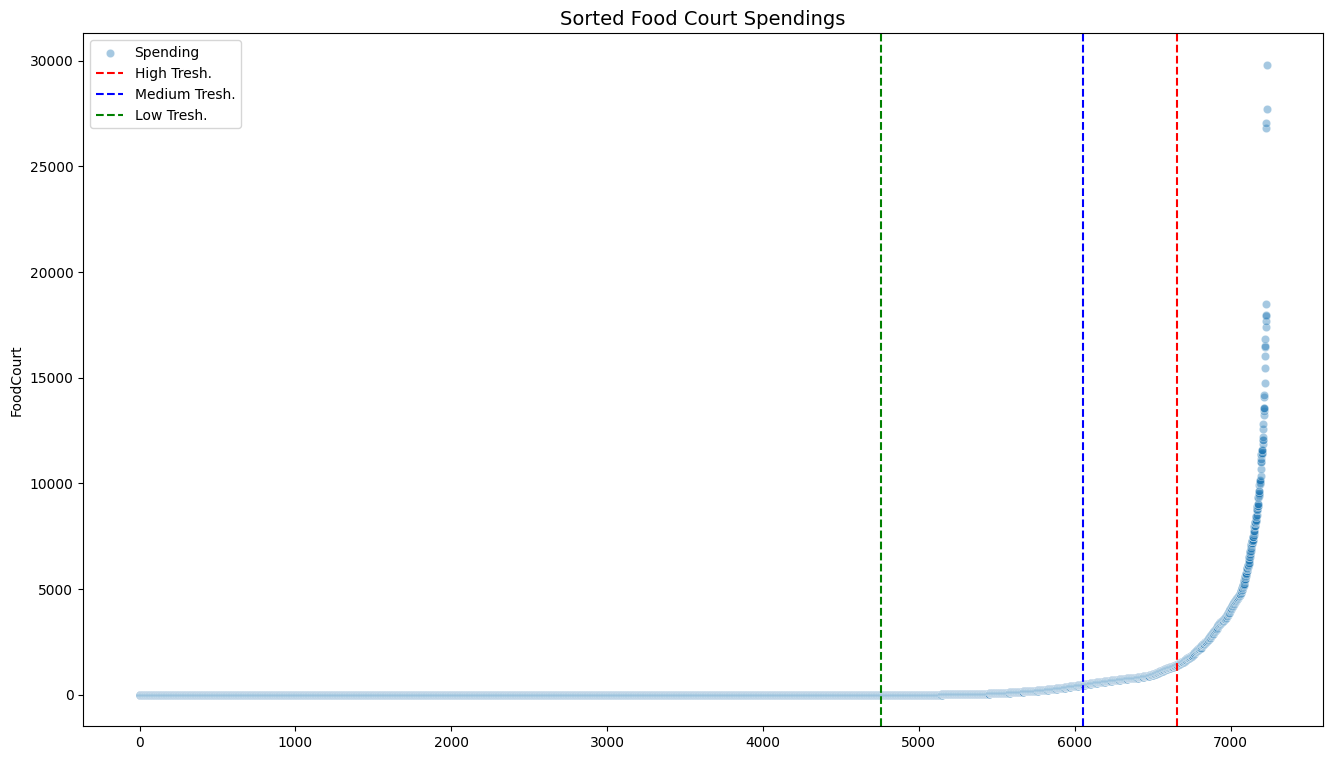

In [404]:
# Spent time visualization on food court
plt.figure(figsize=(16, 9))
sns.scatterplot(data=train.sort_values(by=['FoodCourt']), x=np.arange(len(train)), y='FoodCourt', alpha=0.4)
plt.axvline(x=6653, color='red', label='High Thresh.', ls='--')
plt.axvline(x=6051, color='blue', label='Medium Thresh.', ls='--')
plt.axvline(x=4755, color='green', label='Low Thresh.', ls='--')  # First > 0 value
plt.legend(labels=['Spending', 'High Tresh.', 'Medium Tresh.', 'Low Tresh.'])
plt.title('Sorted Food Court Spendings', fontsize='14');

In [509]:
# Masks for time spent at food court
sorted_values = sorted(train['FoodCourt'])

high_time = train['FoodCourt'] >= sorted_values[6653]
medium_time = (train['FoodCourt'] >= sorted_values[6051]) & (train['FoodCourt'].values < sorted_values[6653])
low_time = (train['FoodCourt'] > 0) & (train['FoodCourt'] < sorted_values[6051])
no_time = train['FoodCourt'] == 0

# Feature generation
train['time_spent_foodcourt'] = np.where(high_time, 3,
                                            np.where(medium_time, 2,
                                                    np.where(low_time, 1,
                                                            np.where(no_time, 0, np.nan))))

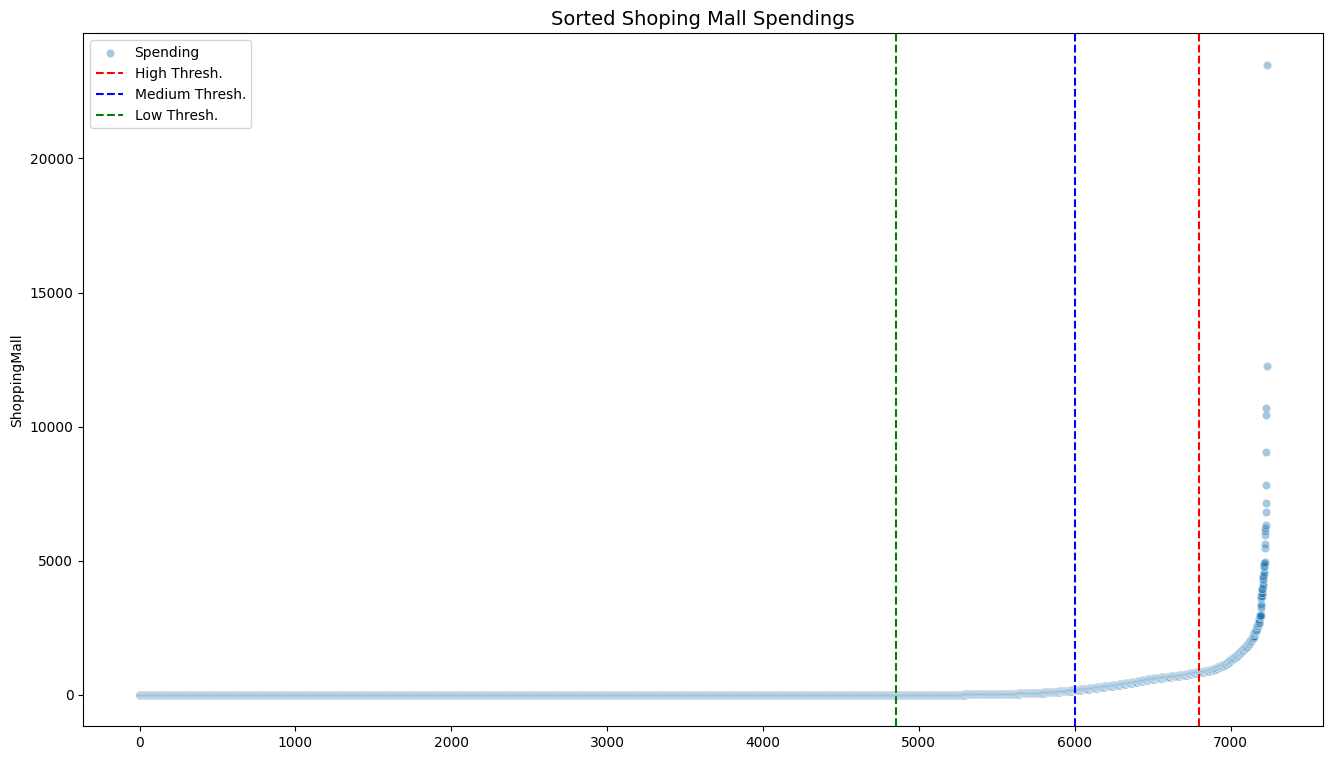

In [406]:
# Spent time visualization on shopping mall
plt.figure(figsize=(16, 9))
sns.scatterplot(data=train.sort_values(by=['ShoppingMall']), x=np.arange(len(train)), y='ShoppingMall', alpha=0.4)
plt.axvline(x=6800, color='red', label='High Thresh.', ls='--')
plt.axvline(x=6000, color='blue', label='Medium Thresh.', ls='--')
plt.axvline(x=4856, color='green', label='Low Thresh.', ls='--')  # First > 0 value
plt.legend(labels=['Spending', 'High Thresh.', 'Medium Thresh.', 'Low Thresh.'])
plt.title('Sorted Shoping Mall Spendings', fontsize='14');

In [512]:
# Masks for time spent at shopping mall
sorted_values = sorted(train['ShoppingMall'])

high_time = train['ShoppingMall'] >= sorted_values[6800]
medium_time = (train['ShoppingMall'] >= sorted_values[6000]) & (train['ShoppingMall'].values < sorted_values[6800])
low_time = (train['ShoppingMall'] > 0) & (train['ShoppingMall'] < sorted_values[6000])
no_time = train['ShoppingMall'] == 0

# Feature generation
train['time_spent_shoppingmall'] = np.where(high_time, 3,
                                            np.where(medium_time, 2,
                                                    np.where(low_time, 1,
                                                            np.where(no_time, 0, np.nan))))

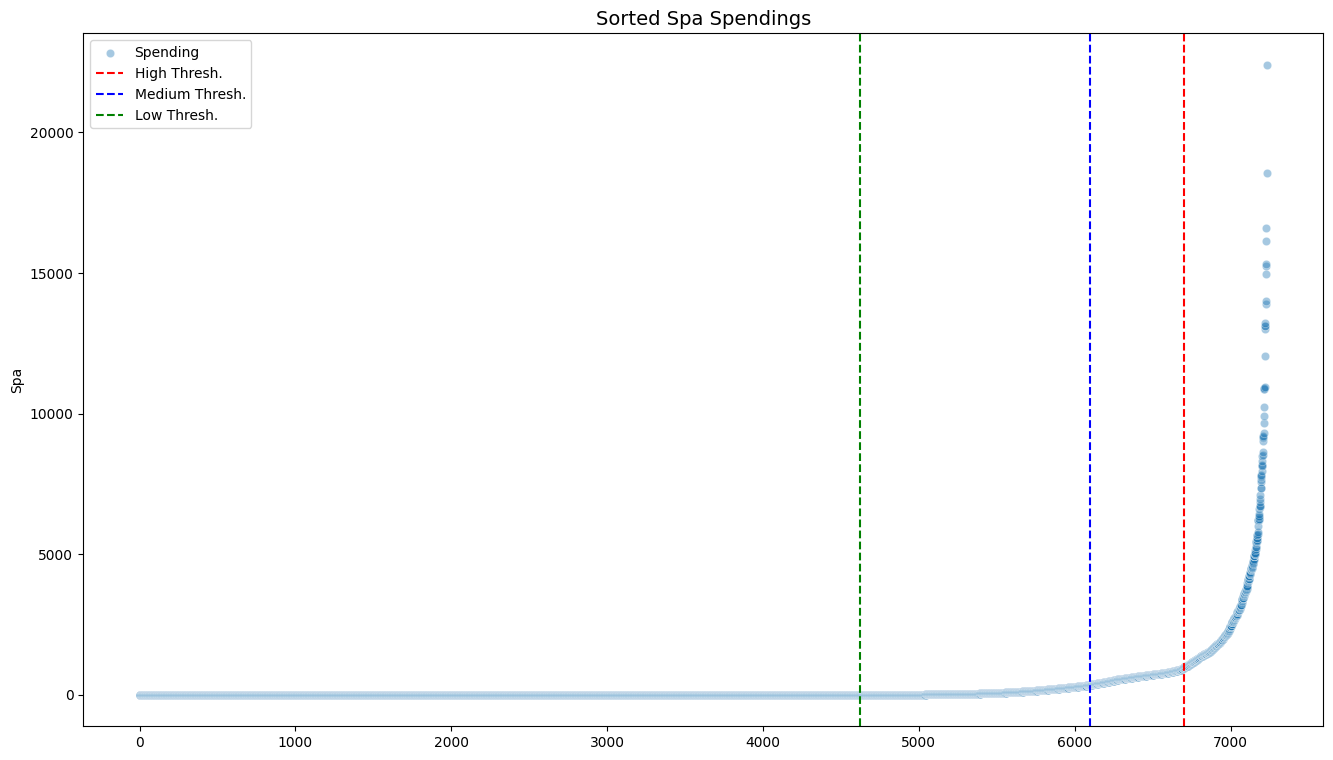

In [408]:
# Spent time visualization on spa
plt.figure(figsize=(16, 9))
sns.scatterplot(data=train.sort_values(by=['Spa']), x=np.arange(len(train)), y='Spa', alpha=0.4)
plt.axvline(x=6700, color='red', label='High Thresh.', ls='--')
plt.axvline(x=6100, color='blue', label='Medium Thresh.', ls='--')
plt.axvline(x=4620, color='green', label='Low Thresh.', ls='--')  # First > 0 value
plt.legend(labels=['Spending', 'High Thresh.', 'Medium Thresh.', 'Low Thresh.'])
plt.title('Sorted Spa Spendings', fontsize='14');

In [516]:
# Masks for time spent at spa
sorted_values = sorted(train['Spa'])

high_time = train['Spa'] >= sorted_values[6700]
medium_time = (train['Spa'] >= sorted_values[6100]) & (train['Spa'] < sorted_values[6700])
low_time = (train['Spa'] > 0) & (train['Spa'] < sorted_values[6100])
no_time = train['Spa'] == 0

# Feature generation
train['time_spent_spa'] = np.where(high_time, 3,
                                            np.where(medium_time, 2,
                                                    np.where(low_time, 1,
                                                            np.where(no_time, 0, np.nan))))

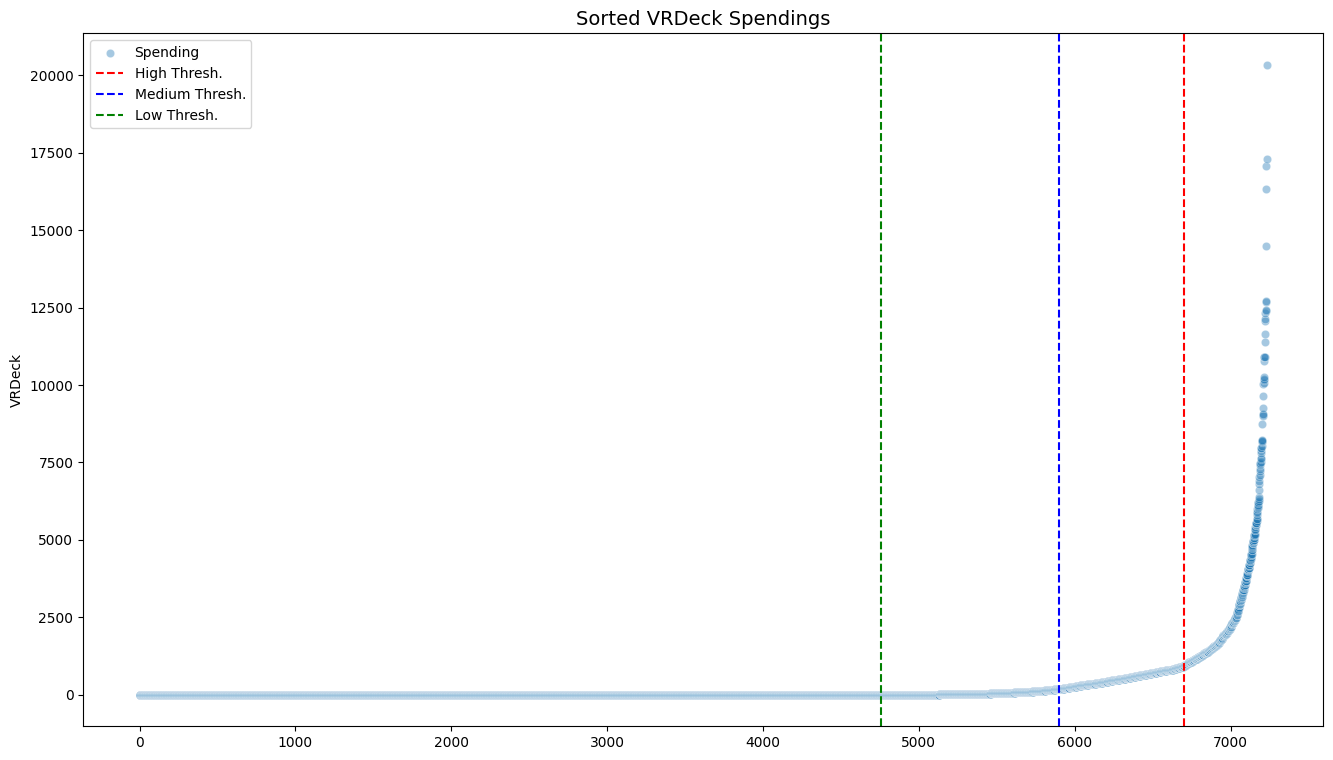

In [410]:
# Spent time visualization on vr deck
plt.figure(figsize=(16, 9))
sns.scatterplot(data=train.sort_values(by=['VRDeck']), x=np.arange(len(train)), y='VRDeck', alpha=0.4)
plt.axvline(x=6700, color='red', label='High Thresh.', ls='--')
plt.axvline(x=5900, color='blue', label='Medium Thresh.', ls='--')
plt.axvline(x=4760, color='green', label='Low Thresh.', ls='--')  # First > 0 value
plt.legend(labels=['Spending', 'High Thresh.', 'Medium Thresh.', 'Low Thresh.'])
plt.title('Sorted VRDeck Spendings', fontsize='14');

In [520]:
# Masks for time spent at vr deck
sorted_values = sorted(train['VRDeck'])

high_time = train['VRDeck'] >= sorted_values[6700]
medium_time = (train['VRDeck'] >= sorted_values[5900]) & (train['VRDeck'] < sorted_values[6700])
low_time = (train['VRDeck'] > 0) & (train['VRDeck'] < sorted_values[5900])
no_time = train['VRDeck'] == 0

# Feature generation
train['time_spent_vrdeck'] = np.where(high_time, 3,
                                            np.where(medium_time, 2,
                                                    np.where(low_time, 1,
                                                            np.where(no_time, 0, np.nan))))

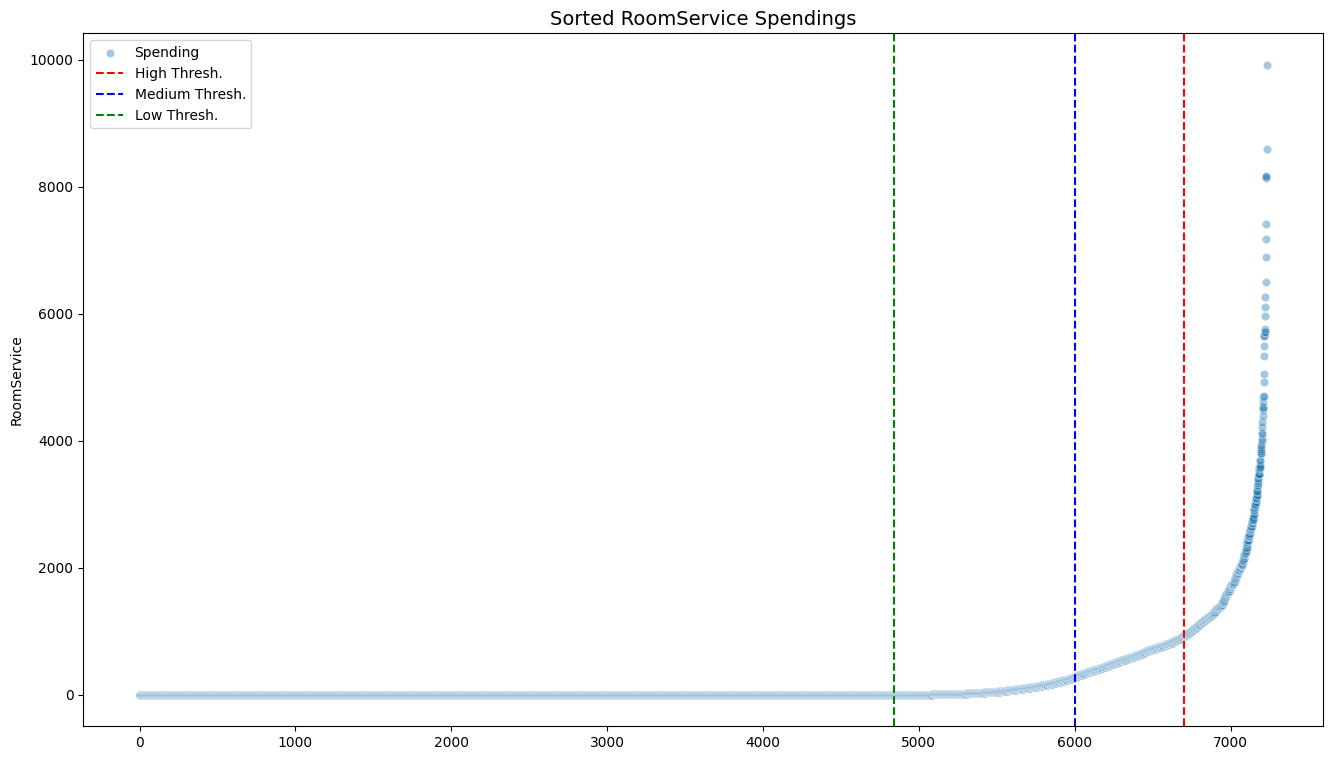

In [412]:
# Spent time on room
plt.figure(figsize=(16, 9))
sns.scatterplot(data=train.sort_values(by=['RoomService']), x=np.arange(len(train)), y='RoomService', alpha=0.4)
plt.axvline(x=6700, color='red', label='High Thresh.', ls='--')
plt.axvline(x=6000, color='blue', label='Medium Thresh.', ls='--')
plt.axvline(x=4843, color='green', label='Low Thresh.', ls='--')  # First > 0 value
plt.legend(labels=['Spending', 'High Thresh.', 'Medium Thresh.', 'Low Thresh.'])
plt.title('Sorted RoomService Spendings', fontsize='14');

In [523]:
# Masks for time spent at room deck
sorted_values = sorted(train['RoomService'])

high_time = train['RoomService'] >= sorted_values[6700]
medium_time = (train['RoomService'] >= sorted_values[6000]) & (train['RoomService'] < sorted_values[6700])
low_time = (train['RoomService'] >= 0) & (train['RoomService'] < sorted_values[6000])

# Feature generation
train['time_spent_room'] = np.where(high_time, 2,
                                            np.where(medium_time, 1,
                                                        np.where(low_time, 0, np.nan)))

In [414]:
# Make the passengers which travels within cyrosleep 3, the highest time spent at the room
train.loc[train['CryoSleep'] == True, 'RoomService'] = 3

In [423]:
# Age grouping
old = train['Age'] >= 65
medium = (train['Age'] >= 30) & (train['Age'] < 65)
young = (train['Age'] >= 12) & (train['Age'] < 30)
child = train['Age'] < 12

# Feature generation
train['age_group'] = np.where(old, 3,
                                    np.where(medium, 2,
                                             np.where(young, 1, 
                                                      np.where(child, 0, np.nan))))

In [422]:
# Destination grouping
# TRAPPIST-1e -->0, PSO J318.5-22 --> 1, 55 Cancri e --> 2
# Feature generation
train['destination_group'] = np.where(train['Destination'] == 'TRAPPIST-1e', 0,
                                    np.where(train['Destination'] == 'PSO J318.5-22', 1,
                                                 np.where(train['Destination'] == '55 Cancri e', 2, np.nan)))

In [426]:
# Home planet grouping
# TRAPPIST-1e -->0, PSO J318.5-22 --> 1, 55 Cancri e --> 2
# Feature generation
train['home_group'] = np.where(train['HomePlanet'] == 'Europa', 0,
                                    np.where(train['HomePlanet'] == 'Earth', 1,
                                                 np.where(train['HomePlanet'] == 'Mars', 2, np.nan)))

In [428]:
# Transported numerization
train['transported'] = np.where(train['Transported'] == True, 1,
                                    np.where(train['Transported'] == False, 0, np.nan))

In [436]:
# Deck numerization
train['deck'] = np.where(train['deck'] == 'A', 0,
                                    np.where(train['deck'] == 'B', 1, 
                                             np.where(train['deck'] == 'C', 2, 
                                                      np.where(train['deck'] == 'D', 3, 
                                                               np.where(train['deck'] == 'E', 4, 
                                                                        np.where(train['deck'] == 'F', 5, 
                                                                                 np.where(train['deck'] == 'G', 6, 
                                                                                          np.where(train['deck'] == 'T', 7, np.nan))))))))

In [439]:
# Side numerization
train['side'] = np.where(train['side'] == 'S', 0,
                                    np.where(train['side'] == 'P', 1, np.nan))

# Model Training

Now we have features. We can train a model and predict the output. We can't identify the best model directly. I will try three models.

## Logistic Regression

In [449]:
X = train[['group', 'deck', 'num', 'side', 'time_spent_foodcourt', 'time_spent_shoppingmall', 
           'time_spent_spa', 'time_spent_vrdeck', 'age_group', 'destination_group', 'home_group']].astype(int)

In [450]:
X.head()

group  deck  num  side  time_spent_foodcourt  time_spent_shoppingmall  \
0      1     1    0     1                     0                        0   
1      2     5    0     0                     1                        1   
2      3     0    0     0                     3                        0   
3      3     0    0     0                     2                        2   
4      4     5    1     0                     1                        1   

   time_spent_spa  time_spent_vrdeck  age_group  destination_group  home_group  
0               0                  0          2                  0           0  
1               2                  1          1                  0           1  
2               3                  1          2                  0           0  
3               3                  2          2                  0           0  
4               2                  1          1                  0           1

In [451]:
y = train['transported'].astype(int)

In [452]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: transported, dtype: int32

In [461]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [477]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [478]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

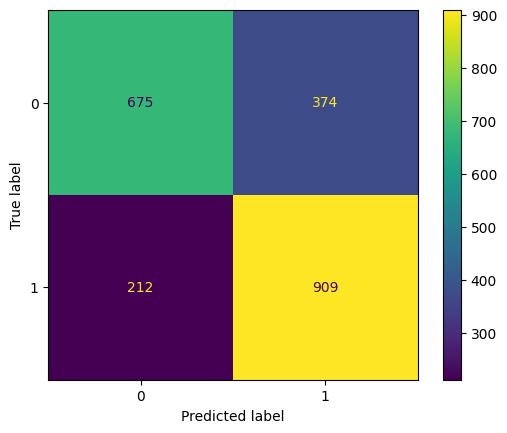

In [479]:
# Confusion matrix for visualize results
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

In [480]:
# Create classification report for logistic regression model
target_names = ['Predicted would not survive', 'Predicted would survive']
print(classification_report(y_test, y_pred, target_names=target_names))

                             precision    recall  f1-score   support

Predicted would not survive       0.76      0.64      0.70      1049
    Predicted would survive       0.71      0.81      0.76      1121

                   accuracy                           0.73      2170
                  macro avg       0.73      0.73      0.73      2170
               weighted avg       0.73      0.73      0.73      2170



Model performed overall 73% f1-score, precision and recall. This performance can increase with other models

## Decision Tree

In [481]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 3, 4, 5],
             'min_samples_split': [2, 4, 6, 8]
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [482]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 11 s
Wall time: 11.2 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 4, 6, 8]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [483]:
# Check best parameters
tree1.best_params_

{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [484]:
# Check best AUC score on CV
tree1.best_score_

0.8482637077409715

In [485]:
def make_results(model_name:str, model_object, metric:str):
    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [486]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.773062  0.788991  0.780655  0.771083  0.848264

Model's AUC score increased dramatically with decision tree model. Also f1-score, precision and recall increased 5%.

## Random Forest

In [491]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3, 5], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [2, 3, 4],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [200, 400],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [492]:
%%time
rf1.fit(X_train, y_train)

CPU times: total: 10min 29s
Wall time: 10min 37s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [200, 400]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [493]:
# Path to the folder where you want to save the model
path = 'models/'

In [494]:
# Model saving function
def write_pickle(path, model_object, save_as:str):  
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [495]:
# Model reading function
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
    return model

In [496]:
# Write pickle
write_pickle(path, rf1, '_rf1')

In [497]:
# Read pickle
rf1 = read_pickle(path, '_rf1')

In [498]:
# Check best AUC score on CV
rf1.best_score_

0.8567758146454927

In [499]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 400}

In [500]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.768894  0.803899  0.785653  0.773454  0.856776


- Overal score is increased
- We will train the model with the whole data

In [501]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [5], 
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [4],
             'min_samples_split': [2],
             'n_estimators': [400],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [502]:
%%time
rf1.fit(X, y) # --> Wall time: ~10min;

CPU times: total: 15.9 s
Wall time: 16 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [4],
                         'min_samples_split': [2], 'n_estimators': [400]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [503]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1_full')

In [504]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1_full')

In [505]:
# Check best AUC score on CV
rf1.best_score_

0.8475805675861133

# Test Data Preprocessing

In [572]:
# See the test set
test.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez

Same data preperation steps to the test set

In [573]:
# Finding missing value ratio for each feature
(test.isna().sum() / len(train)) * 100

PassengerId     0.000000
HomePlanet      1.000805
CryoSleep       1.069826
Cabin           1.150351
Destination     1.058323
Age             1.046819
VIP             1.069826
RoomService     0.943288
FoodCourt       1.219372
ShoppingMall    1.127344
Spa             1.161854
VRDeck          0.920281
Name            1.081330
dtype: float64

In [574]:
# Distrubution for non-numeric columns
def take_dist(column):
    return test[column].value_counts(normalize=True)

In [575]:
# Finding missing value ratio for each feature
(test.isna().sum() / len(train)) * 100

PassengerId     0.000000
HomePlanet      1.000805
CryoSleep       1.069826
Cabin           1.150351
Destination     1.058323
Age             1.046819
VIP             1.069826
RoomService     0.943288
FoodCourt       1.219372
ShoppingMall    1.127344
Spa             1.161854
VRDeck          0.920281
Name            1.081330
dtype: float64

In [578]:
# Handling nan values
test = test.drop(['Name'], axis=1)
test.loc[test['CryoSleep'] == True, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = 0
test.loc[test['Age'].isna(), 'Age'] = test['Age'].mean()
test.loc[test['FoodCourt'].isna(), 'FoodCourt'] = test['FoodCourt'].mean()
test.loc[test['RoomService'].isna(), 'RoomService'] = test['RoomService'].mean()
test.loc[test['ShoppingMall'].isna(), 'ShoppingMall'] = test['ShoppingMall'].mean()
test.loc[test['Spa'].isna(), 'Spa'] = test['Spa'].mean()
test.loc[test['VRDeck'].isna(), 'VRDeck'] = test['VRDeck'].mean()
test.loc[test['HomePlanet'].isna(), 'HomePlanet'] = choice(take_dist('HomePlanet').index, p=take_dist('HomePlanet').values)
test.loc[test['CryoSleep'].isna(), 'CryoSleep'] = choice(take_dist('CryoSleep').index, p=take_dist('CryoSleep').values)
test.loc[test['Cabin'].isna(), 'Cabin'] = choice(take_dist('Cabin').index, p=take_dist('Cabin').values)
test.loc[test['Destination'].isna(), 'Destination'] = choice(take_dist('Destination').index, p=take_dist('Destination').values)
test.loc[test['VIP'].isna(), 'VIP'] = choice(take_dist('VIP').index, p=take_dist('VIP').values)
test = test.reset_index(drop=True)

In [579]:
# Check missing values again
(test.isna().sum() / len(train)) * 100

PassengerId     0.0
HomePlanet      0.0
CryoSleep       0.0
Cabin           0.0
Destination     0.0
Age             0.0
VIP             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

In [580]:
# Data Preperation
test['group'] = test['PassengerId'].apply(split_group)
deck, num, side = [], [], [] 
test['Cabin'].apply(split_cabin)
test['deck'] = deck
test['num'] = num
test['side'] = side
# Data Grouping - Food Court
high_time = test['FoodCourt'] >= 1409.0
medium_time = (test['FoodCourt'] >= 478.0) & (test['FoodCourt'].values < 1409.0)
low_time = (test['FoodCourt'] > 0) & (test['FoodCourt'] < 478.0)
no_time = test['FoodCourt'] == 0

# Feature generation
test['time_spent_foodcourt'] = np.where(high_time, 3,
                                            np.where(medium_time, 2,
                                                    np.where(low_time, 1,
                                                            np.where(no_time, 0, np.nan))))

# Data Grouping - Shopping Mall
high_time = test['ShoppingMall'] >= 849.0
medium_time = (test['ShoppingMall'] >= 174.0) & (test['ShoppingMall'].values < 849.0)
low_time = (test['ShoppingMall'] > 0) & (test['ShoppingMall'] < 174.0)
no_time = test['ShoppingMall'] == 0

# Feature generation
test['time_spent_shoppingmall'] = np.where(high_time, 3,
                                            np.where(medium_time, 2,
                                                    np.where(low_time, 1,
                                                            np.where(no_time, 0, np.nan))))
# Data Grouping - Spa
high_time = test['Spa'] >= 960.0
medium_time = (test['Spa'] >= 356.0) & (test['Spa'] < 960.0)
low_time = (test['Spa'] > 0) & (test['Spa'] < 960.0)
no_time = test['Spa'] == 0

# Feature generation
test['time_spent_spa'] = np.where(high_time, 3,
                                            np.where(medium_time, 2,
                                                    np.where(low_time, 1,
                                                            np.where(no_time, 0, np.nan))))

# Data Grouping - VR Deck
high_time = test['VRDeck'] >= 927.0
medium_time = (test['VRDeck'] >= 186.0) & (test['VRDeck'] < 927.0)
low_time = (test['VRDeck'] > 0) & (test['VRDeck'] < 186.0)
no_time = test['VRDeck'] == 0

# Feature generation
test['time_spent_vrdeck'] = np.where(high_time, 3,
                                            np.where(medium_time, 2,
                                                    np.where(low_time, 1,
                                                            np.where(no_time, 0, np.nan))))
# Masks for time spent at room deck
high_time = test['RoomService'] >= 931.0
medium_time = (test['RoomService'] >= 281.0) & (test['RoomService'] < 931.0)
low_time = (test['RoomService'] >= 0) & (test['RoomService'] < 281.0)

# Feature generation
test['time_spent_room'] = np.where(high_time, 2,
                                            np.where(medium_time, 1,
                                                        np.where(low_time, 0, np.nan)))

# Make the passengers which travels within cyrosleep 3, the highest time spent at the room
test.loc[test['CryoSleep'] == True, 'RoomService'] = 3

# Age grouping
old = test['Age'] >= 65
medium = (test['Age'] >= 30) & (test['Age'] < 65)
young = (test['Age'] >= 12) & (test['Age'] < 30)
child = test['Age'] < 12

# Feature generation
test['age_group'] = np.where(old, 3,
                                    np.where(medium, 2,
                                             np.where(young, 1, 
                                                      np.where(child, 0, np.nan))))

# Destination grouping
test['destination_group'] = np.where(test['Destination'] == 'TRAPPIST-1e', 0,
                                    np.where(test['Destination'] == 'PSO J318.5-22', 1,
                                                 np.where(test['Destination'] == '55 Cancri e', 2, np.nan)))

# Home planet grouping
test['home_group'] = np.where(test['HomePlanet'] == 'Europa', 0,
                                    np.where(test['HomePlanet'] == 'Earth', 1,
                                                 np.where(test['HomePlanet'] == 'Mars', 2, np.nan)))

# Deck numerization
test['deck'] = np.where(test['deck'] == 'A', 0,
                                    np.where(test['deck'] == 'B', 1, 
                                             np.where(test['deck'] == 'C', 2, 
                                                      np.where(test['deck'] == 'D', 3, 
                                                               np.where(test['deck'] == 'E', 4, 
                                                                        np.where(test['deck'] == 'F', 5, 
                                                                                 np.where(test['deck'] == 'G', 6, 
                                                                                          np.where(test['deck'] == 'T', 7, np.nan))))))))

# Side numerization
test['side'] = np.where(test['side'] == 'S', 0,
                                    np.where(test['side'] == 'P', 1, np.nan))

# Predictions

In [581]:
X = test[['group', 'deck', 'num', 'side', 'time_spent_foodcourt', 'time_spent_shoppingmall', 
           'time_spent_spa', 'time_spent_vrdeck', 'age_group', 'destination_group', 'home_group']].astype(int)

In [582]:
X.head()

group  deck  num  side  time_spent_foodcourt  time_spent_shoppingmall  \
0     13     6    3     0                     0                        0   
1     18     5    4     0                     1                        0   
2     19     2    0     0                     0                        0   
3     21     2    1     0                     3                        0   
4     23     5    5     0                     0                        2   

   time_spent_spa  time_spent_vrdeck  age_group  destination_group  home_group  
0               0                  0          1                  0           1  
1               3                  0          1                  0           1  
2               0                  0          2                  2           0  
3               1                  2          2                  0           0  
4               0                  0          1                  0           1

In [583]:
# Make predictions
predictions = rf1.predict(X)

In [584]:
# Prepare the result csv
result = pd.DataFrame()
result['PassengerId'] = test['PassengerId']
result['Transported'] = predictions

In [585]:
# Binary to boolean result
result['Transported'] = np.where(result['Transported'] == 1, 'True',
                                    np.where(result['Transported'] == 0, 'False', np.nan))

In [587]:
# Get the result csv
result.to_csv('results/spaceship_prediction_2-01-24.csv', index=False)

In [588]:
result.head()

PassengerId Transported
0     0013_01        True
1     0018_01       False
2     0019_01        True
3     0021_01        True
4     0023_01       False